In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


En la presente implementación, estaremos trabajando con una base de datos de series de tiempo recolectada en el Weather Station del Instituto Max Planck para Biogeoquímica, ubicando en Jena, Alemania (http://www.bgc-jena.mpg.de/wetter/) <br>

En esta base de datos, 14 cantidades diferentes (incluyendo temperatura del aire, presión atmosférica, humedad y dirección del aire) se registraron cada 10 minutos a los largo de mucho años. La base de datos original comenzó a construirse en el 2003, pero en nuestro caso, usaremos sólo la información del período 2009-2016. Nuestra intención al usar esta base de datos es tomar cierta información atmosférica del pasado reciente para predecir la temperatura del aire 24 horas después. Específicamente, se estarán tomando como datos de entrada, la información atmosférica de algunos días en el pasada.

# **Descomprimimos la base de datos**

In [2]:
!mkdir jena_climate
!cd jena_climate
!wget https://s3.amazonaws.com/keras-datasets/jena_climate_2009_2016.csv.zip
!unzip jena_climate_2009_2016.csv.zip

--2021-01-09 16:11:54--  https://s3.amazonaws.com/keras-datasets/jena_climate_2009_2016.csv.zip
Resolving s3.amazonaws.com (s3.amazonaws.com)... 52.217.70.166
Connecting to s3.amazonaws.com (s3.amazonaws.com)|52.217.70.166|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 13565642 (13M) [application/zip]
Saving to: ‘jena_climate_2009_2016.csv.zip’

jena_climate_2009_2 100%[===================>]  12.94M  18.5MB/s    in 0.7s    

2021-01-09 16:11:55 (18.5 MB/s) - ‘jena_climate_2009_2016.csv.zip’ saved [13565642/13565642]

Archive:  jena_climate_2009_2016.csv.zip
  inflating: jena_climate_2009_2016.csv  
  inflating: __MACOSX/._jena_climate_2009_2016.csv  


In [3]:
import os

fname = 'jena_climate_2009_2016.csv'

f = open(fname)
data = f.read()
f.close()

lines = data.split('\n')
header = lines[0].split(',')
lines = lines[1:]

print(header)
print(len(lines))

['"Date Time"', '"p (mbar)"', '"T (degC)"', '"Tpot (K)"', '"Tdew (degC)"', '"rh (%)"', '"VPmax (mbar)"', '"VPact (mbar)"', '"VPdef (mbar)"', '"sh (g/kg)"', '"H2OC (mmol/mol)"', '"rho (g/m**3)"', '"wv (m/s)"', '"max. wv (m/s)"', '"wd (deg)"']
420451


In [4]:
lines[0]

'01.01.2009 00:10:00,996.52,-8.02,265.40,-8.90,93.30,3.33,3.11,0.22,1.94,3.12,1307.75,1.03,1.75,152.30'

In [5]:
#Convertimos las líneas (timesteps) en un numpy array
import numpy as np

float_data = np.zeros((len(lines), len(header) - 1))
for i, line in enumerate(lines):
    values = [float(x) for x in line.split(',')[1:]]
    float_data[i, :] = values

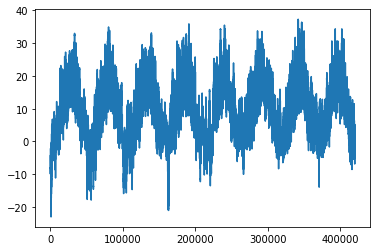

In [6]:
#Temperatura registrada en todo el rango temporal de la base de datos
from matplotlib import pyplot as plt

temp = float_data[:, 1]  # temperatura (en grados Celsius)
plt.plot(range(len(temp)), temp)
plt.show()

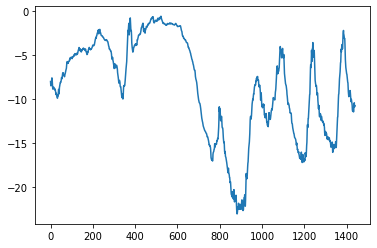

In [7]:
#Temperatura registrada en los primeros 10 días
plt.plot(range(1440), temp[:1440])
plt.show()

# **Preparación de los datos**

La formulación exacta del problema será la siguiente: considerando datos que provienen de *looback* timesteps (recuerda que un timesteps son 10 minutos) y muestreados cada *steps* timesteps, ¿podremos predecir la temperatura en *delay* timesteps?
Para afrontar este problema, usaremos los siguientes parámetros:

lookback = 1440, i.e. usaremos datos de hace 10 días. <br>
steps = 6, i.e. los datos serán muestreados cada hora. <br>
delay = 144, i.e. las etiquetas corresponderán a la temperatura del aire 24 horas en el futuro. <br>

**Normalizamos la base de datos**

In [8]:
mean = float_data[:200000].mean(axis=0)
float_data -= mean
std = float_data[:200000].std(axis=0)
float_data /= std

**Construcción de un generador de datos**

Con el objetivo de extraer los datos temporales de la base de datos y emplearlos para entrenar nuestro modelo, se recomienda diseñar un generador de datos. Este generador producirá una tupla *(samples, targets)*, donde *samples* es un batch de datos de entrada y *targets* es un arreglo que almacena la temperatura 24 horas después. El generador requiere que se especifiquen los siguientes argumentos:<br> <br>
data: Los datos originales en punto flotante, los cuales normalizamos previamente. <br>
lookback: Cuantos timesteps en el pasado debemos considerar como datos de entrada. <br>
delay: Cuantos timesteps en el futuro debemos considerar para las etiquetas. <br>
min_index y max_index: Útiles para particionar la base de datos en conjuntos de entrenamiento, validación y prueba. <br>
shuffle: Aplicar shuffling en las muestras o extraerlas cronológicamente. <br>
step: El período, en timesteps, en el que muestreamos los datos. Su valor será de 6, para indicar que estaremos muestreando datos cada hora.

In [9]:
def generator(data, lookback, delay, min_index, max_index,
              shuffle=False, batch_size=128, step=6):
    if max_index is None:
        max_index = len(data) - delay - 1
    i = min_index + lookback
    while 1:
        if shuffle:
            rows = np.random.randint(
                min_index + lookback, max_index, size=batch_size)
        else:
            if i + batch_size >= max_index:
                i = min_index + lookback
            rows = np.arange(i, min(i + batch_size, max_index))
            i += len(rows)

        samples = np.zeros((len(rows),
                           lookback // step,
                           data.shape[-1]))
        targets = np.zeros((len(rows),))
        for j, row in enumerate(rows):
            indices = range(rows[j] - lookback, rows[j], step)
            samples[j] = data[indices]
            targets[j] = data[rows[j] + delay][1]
        yield samples, targets

Ahora, vamos a usar la función generator para crear tres generador: uno para el conjunto de entrenamiento, otro para el conjunto de validación y el último para el conjunto de prueba. Cada generador tomará información de diferentes segmentos temporales de la base de datos: el generador de entrenamiento usará los primeros 200,00 timesteps, mientras que el generador de validación empleará los siguientes 100,000 timesteps. Por su parte, el generador de prueba extraerá los timesteps restantes.

In [10]:
lookback = 1440
step = 6
delay = 144
batch_size = 128

train_gen = generator(float_data,
                      lookback=lookback,
                      delay=delay,
                      min_index=0,
                      max_index=200000,
                      shuffle=True,
                      step=step, 
                      batch_size=batch_size)
val_gen = generator(float_data,
                    lookback=lookback,
                    delay=delay,
                    min_index=200001,
                    max_index=300000,
                    step=step,
                    batch_size=batch_size)
test_gen = generator(float_data,
                     lookback=lookback,
                     delay=delay,
                     min_index=300001,
                     max_index=None,
                     step=step,
                     batch_size=batch_size)

# Esta variable nos permite definir cuantas veces se tiene
# que iterar en "validation_gen" para procesar todo el conjunto de validación.
val_steps = (300000 - 200001 - lookback) // batch_size

# Esta variable nos permite definir cuantas veces se tiene
# que iterar en "test_gen" para procesar todo el conjunto de prueba.
test_steps = (len(float_data) - 300001 - lookback) // batch_size

# **Definimos la arquitectura recurrente GRU**

In [11]:
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ModelCheckpoint

model = Sequential()
model.add(layers.GRU(32, input_shape=(None, float_data.shape[-1])))
model.add(layers.Dense(1))

model.compile(optimizer=RMSprop(), loss='mae')

es = EarlyStopping(monitor= 'val_loss', mode='min', patience = 10, verbose=1)
mc = ModelCheckpoint('/content/model_gru.h5', monitor='val_loss', mode='min', verbose=1, save_best_only=True)

history = model.fit(train_gen,
                              steps_per_epoch=500,
                              epochs=20,
                              validation_data=val_gen,
                              validation_steps=val_steps,
                              callbacks = [es, mc])

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/20
500/500 [==============================] - 23s 32ms/step - loss: 0.3457 - val_loss: 0.2729

Epoch 00001: val_loss improved from inf to 0.27287, saving model to /content/model_gru.h5
Epoch 2/20
500/500 [==============================] - 15s 30ms/step - loss: 0.2892 - val_loss: 0.2690

Epoch 00002: val_loss improved from 0.27287 to 0.26900, saving model to /content/model_gru.h5
Epoch 3/20
500/500 [==============================] - 15s 30ms/step - loss: 0.2798 - val_loss: 0.2649

Epoch 00003: val_loss improved from 0.26900 to 0.26494, saving model to /content/model_gru.h5
Epoch 4/20
500/500 [==============================] - 15s 31ms/step - loss: 0.2747 - val_loss: 0.2615

Epoch 00004: val_loss improved from 0.26494 to 0.26149, saving model to /content/model_gru.h5
Epoch 5/20
500/500 [==============================] - 15s 31ms/step - loss: 0.2736 - val_loss: 0.2683

Epoch 00005: val_loss did not improve from 0.26149
Epoch 6/20
500/500 [==============================] - 15s 31ms

# **Curva de pérdida**

Best loss epoch :  6, Value :  0.2609483600


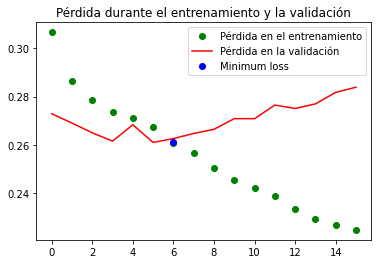

In [13]:
import matplotlib.pyplot as plt

loss = history.history['loss']
val_loss = history.history['val_loss']
min_val_loss = min(val_loss)
min_val_loss_epoch= val_loss.index(min(val_loss)) + 1

epochs = range(len(loss))

plt.plot(epochs, loss, 'go', label='Pérdida en el entrenamiento')
plt.plot(epochs, val_loss, 'r', label='Pérdida en la validación')
plt.plot(min_val_loss_epoch, min_val_loss, 'bo', label='Minimum loss')
plt.title('Pérdida durante el entrenamiento y la validación')
plt.legend()
print("Best loss epoch : % d, Value : % .10f" %(min_val_loss_epoch, min_val_loss))

plt.show()

# **Uso de recurrent dropout como regularizador**

In [16]:
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras.optimizers import RMSprop

model = Sequential()
model.add(layers.GRU(32,
                     dropout=0.2,
                     recurrent_dropout=0.2,
                     input_shape=(None, float_data.shape[-1])))
model.add(layers.Dense(1))

model.compile(optimizer=RMSprop(), loss='mae')

es = EarlyStopping(monitor= 'val_loss', mode='min', patience = 10, verbose=1)
mc = ModelCheckpoint('/content/model_gru1.h5', monitor='val_loss', mode='min', verbose=1, save_best_only=True)

history = model.fit(train_gen,
                              steps_per_epoch=500,
                              epochs=40,
                              validation_data=val_gen,
                              validation_steps=val_steps,
                              callbacks = [es, mc])

Epoch 1/40
500/500 [==============================] - 422s 842ms/step - loss: 0.3524 - val_loss: 0.2819

Epoch 00001: val_loss improved from inf to 0.28194, saving model to /content/model_gru1.h5
Epoch 2/40
315/500 [=================>............] - ETA: 2:15 - loss: 0.3095

KeyboardInterrupt: ignored

# **Curva de pérdida**

Best accuracy epoch :  4, Value :  0.8709999919
Best loss epoch :  4, Value :  0.3455053568


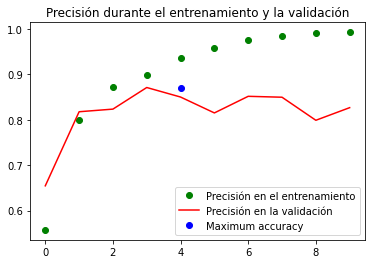

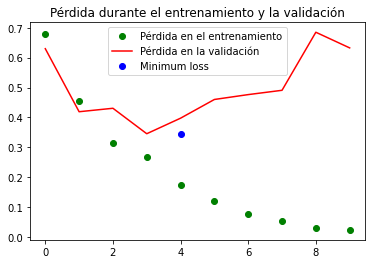

In [ ]:
import matplotlib.pyplot as plt

loss = history.history['loss']
val_loss = history.history['val_loss']
min_val_loss = min(val_loss)
min_val_loss_epoch= val_loss.index(min(val_loss)) + 1

epochs = range(len(loss))

plt.plot(epochs, loss, 'go', label='Pérdida en el entrenamiento')
plt.plot(epochs, val_loss, 'r', label='Pérdida en la validación')
plt.plot(min_val_loss_epoch, min_val_loss, 'bo', label='Minimum loss')
plt.title('Pérdida durante el entrenamiento y la validación')
plt.legend()
print("Best loss epoch : % d, Value : % .10f" %(min_val_loss_epoch, min_val_loss))

plt.show()

# **Red neuronal recurrente profunda**

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras.optimizers import RMSprop

model = Sequential()
model.add(layers.GRU(32,
                     dropout=0.1,
                     recurrent_dropout=0.5,
                     return_sequences=True,
                     input_shape=(None, float_data.shape[-1])))
model.add(layers.GRU(64, activation='relu',
                     dropout=0.1, 
                     recurrent_dropout=0.5))
model.add(layers.Dense(1))

model.compile(optimizer=RMSprop(), loss='mae')

es = EarlyStopping(monitor= 'val_loss', mode='min', patience = 10, verbose=1)
mc = ModelCheckpoint('/content/model_gru2.h5', monitor='val_loss', mode='min', verbose=1, save_best_only=True)

history = model.fit(train_gen,
                    steps_per_epoch=500,
                    epochs=40,
                    validation_data=val_gen,
                    validation_steps=val_steps,
                    callbacks = [es, mc])

# **Curva de pérdida**

Best accuracy epoch :  4, Value :  0.8709999919
Best loss epoch :  4, Value :  0.3455053568


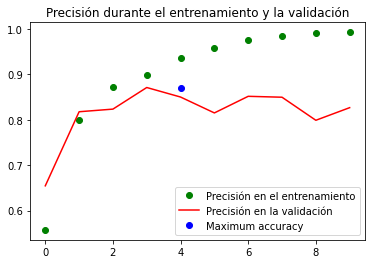

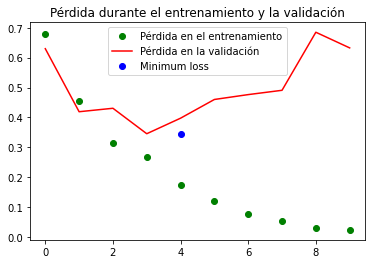

In [ ]:
import matplotlib.pyplot as plt

loss = history.history['loss']
val_loss = history.history['val_loss']
min_val_loss = min(val_loss)
min_val_loss_epoch= val_loss.index(min(val_loss)) + 1

epochs = range(len(loss))

plt.plot(epochs, loss, 'go', label='Pérdida en el entrenamiento')
plt.plot(epochs, val_loss, 'r', label='Pérdida en la validación')
plt.plot(min_val_loss_epoch, min_val_loss, 'bo', label='Minimum loss')
plt.title('Pérdida durante el entrenamiento y la validación')
plt.legend()
print("Best loss epoch : % d, Value : % .10f" %(min_val_loss_epoch, min_val_loss))

plt.show()

# **Redes neuronales recurrentes bidireccionales**

In [17]:
def reverse_order_generator(data, lookback, delay, min_index, max_index,
                            shuffle=False, batch_size=128, step=6):
    if max_index is None:
        max_index = len(data) - delay - 1
    i = min_index + lookback
    while 1:
        if shuffle:
            rows = np.random.randint(
                min_index + lookback, max_index, size=batch_size)
        else:
            if i + batch_size >= max_index:
                i = min_index + lookback
            rows = np.arange(i, min(i + batch_size, max_index))
            i += len(rows)

        samples = np.zeros((len(rows),
                           lookback // step,
                           data.shape[-1]))
        targets = np.zeros((len(rows),))
        for j, row in enumerate(rows):
            indices = range(rows[j] - lookback, rows[j], step)
            samples[j] = data[indices]
            targets[j] = data[rows[j] + delay][1]
        yield samples[:, ::-1, :], targets
        
train_gen_reverse = reverse_order_generator(
    float_data,
    lookback=lookback,
    delay=delay,
    min_index=0,
    max_index=200000,
    shuffle=True,
    step=step, 
    batch_size=batch_size)
val_gen_reverse = reverse_order_generator(
    float_data,
    lookback=lookback,
    delay=delay,
    min_index=200001,
    max_index=300000,
    step=step,
    batch_size=batch_size)

In [18]:
model = Sequential()
model.add(layers.GRU(32, input_shape=(None, float_data.shape[-1])))
model.add(layers.Dense(1))

model.compile(optimizer=RMSprop(), loss='mae')

es = EarlyStopping(monitor= 'val_loss', mode='min', patience = 10, verbose=1)
mc = ModelCheckpoint('/content/model_gru3.h5', monitor='val_loss', mode='min', verbose=1, save_best_only=True)

history = model.fit(train_gen_reverse,
                    steps_per_epoch=500,
                    epochs=20,
                    validation_data=val_gen_reverse,
                    validation_steps=val_steps,
                    callbacks = [es, mc])

Epoch 1/20
500/500 [==============================] - 17s 32ms/step - loss: 0.4982 - val_loss: 0.4772

Epoch 00001: val_loss improved from inf to 0.47718, saving model to /content/model_gru3.h5
Epoch 2/20
500/500 [==============================] - 16s 31ms/step - loss: 0.4429 - val_loss: 0.4645

Epoch 00002: val_loss improved from 0.47718 to 0.46447, saving model to /content/model_gru3.h5
Epoch 3/20
500/500 [==============================] - 16s 31ms/step - loss: 0.4119 - val_loss: 0.4478

Epoch 00003: val_loss improved from 0.46447 to 0.44780, saving model to /content/model_gru3.h5
Epoch 4/20
500/500 [==============================] - 16s 32ms/step - loss: 0.3854 - val_loss: 0.4357

Epoch 00004: val_loss improved from 0.44780 to 0.43568, saving model to /content/model_gru3.h5
Epoch 5/20
500/500 [==============================] - 15s 30ms/step - loss: 0.3655 - val_loss: 0.4491

Epoch 00005: val_loss did not improve from 0.43568
Epoch 6/20
500/500 [==============================] - 15s 

# **Curva de pérdida**

Best loss epoch :  11, Value :  0.3988719285


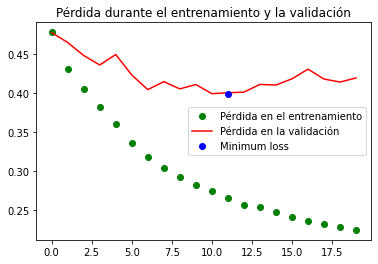

In [19]:
import matplotlib.pyplot as plt

loss = history.history['loss']
val_loss = history.history['val_loss']
min_val_loss = min(val_loss)
min_val_loss_epoch= val_loss.index(min(val_loss)) + 1

epochs = range(len(loss))

plt.plot(epochs, loss, 'go', label='Pérdida en el entrenamiento')
plt.plot(epochs, val_loss, 'r', label='Pérdida en la validación')
plt.plot(min_val_loss_epoch, min_val_loss, 'bo', label='Minimum loss')
plt.title('Pérdida durante el entrenamiento y la validación')
plt.legend()
print("Best loss epoch : % d, Value : % .10f" %(min_val_loss_epoch, min_val_loss))

plt.show()

# **Aplicación del enfoque bidireccional en la base de datos IMDB**

In [20]:
from tensorflow.keras.datasets import imdb
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

# Number of words to consider as features
max_features = 10000
# Cut texts after this number of words (among top max_features most common words)
maxlen = 500

# Load data
(x_train, y_train), (x_test, y_test) = imdb.load_data(num_words=max_features)

# Reverse sequences
x_train = [x[::-1] for x in x_train]
x_test = [x[::-1] for x in x_test]

# Pad sequences
x_train = sequence.pad_sequences(x_train, maxlen=maxlen)
x_test = sequence.pad_sequences(x_test, maxlen=maxlen)

model = Sequential()
model.add(layers.Embedding(max_features, 128))
model.add(layers.LSTM(32))
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['acc'])

es = EarlyStopping(monitor= 'val_acc', mode='max', patience = 10, verbose=1)
mc = ModelCheckpoint('/content/model_gru4.h5', monitor='val_acc', mode='max', verbose=1, save_best_only=True)

history = model.fit(x_train, y_train,
                    epochs=10,
                    batch_size=128,
                    validation_split=0.2,
                    callbacks = [es, mc])

SyntaxError: ignored

# **Curvas de precisión y pérdida**

In [ ]:
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
max_val_acc = max(val_acc)
max_val_acc_epoch= val_acc.index(max(val_acc)) + 1
loss = history.history['loss']
val_loss = history.history['val_loss']
min_val_loss = min(val_loss)
min_val_loss_epoch= val_loss.index(min(val_loss)) + 1

epochs = range(len(acc))

plt.plot(epochs, acc, 'go', label='Precisión en el entrenamiento')
plt.plot(epochs, val_acc, 'r', label='Precisión en la validación')
plt.plot(max_val_acc_epoch, max_val_acc, 'bo', label='Maximum accuracy')
plt.title('Precisión durante el entrenamiento y la validación')
plt.legend()
print("Best accuracy epoch : % d, Value : % .1f" %(max_val_acc_epoch, max_val_acc)) 
plt.figure()

plt.plot(epochs, loss, 'go', label='Pérdida en el entrenamiento')
plt.plot(epochs, val_loss, 'r', label='Pérdida en la validación')
plt.plot(min_val_loss_epoch, min_val_loss, 'bo', label='Minimum loss')
plt.title('Pérdida durante el entrenamiento y la validación')
plt.legend()
print("Best loss epoch : % d, Value : % .10f" %(min_val_loss_epoch, min_val_loss))

plt.show()

# **Implementamos una RNN bidireccional para la base de datos IMDB**

In [ ]:
model = Sequential()
model.add(layers.Embedding(max_features, 32))
model.add(layers.Bidirectional(layers.LSTM(32)))
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])

es = EarlyStopping(monitor= 'val_acc', mode='max', patience = 10, verbose=1)
mc = ModelCheckpoint('/content/model_gru5.h5', monitor='val_acc', mode='max', verbose=1, save_best_only=True)

history = model.fit(x_train, y_train, epochs=10, batch_size=128, validation_split=0.2, callbacks = [es, mc])

# **Curvas de precisión y pérdida**

In [ ]:
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
max_val_acc = max(val_acc)
max_val_acc_epoch= val_acc.index(max(val_acc)) + 1
loss = history.history['loss']
val_loss = history.history['val_loss']
min_val_loss = min(val_loss)
min_val_loss_epoch= val_loss.index(min(val_loss)) + 1

epochs = range(len(acc))

plt.plot(epochs, acc, 'go', label='Precisión en el entrenamiento')
plt.plot(epochs, val_acc, 'r', label='Precisión en la validación')
plt.plot(max_val_acc_epoch, max_val_acc, 'bo', label='Maximum accuracy')
plt.title('Precisión durante el entrenamiento y la validación')
plt.legend()
print("Best accuracy epoch : % d, Value : % .1f" %(max_val_acc_epoch, max_val_acc)) 
plt.figure()

plt.plot(epochs, loss, 'go', label='Pérdida en el entrenamiento')
plt.plot(epochs, val_loss, 'r', label='Pérdida en la validación')
plt.plot(min_val_loss_epoch, min_val_loss, 'bo', label='Minimum loss')
plt.title('Pérdida durante el entrenamiento y la validación')
plt.legend()
print("Best loss epoch : % d, Value : % .10f" %(min_val_loss_epoch, min_val_loss))

plt.show()

# **Implementamos una RNN bidireccional para la base de datos de series de tiempo**

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras.optimizers import RMSprop

model = Sequential()
model.add(layers.Bidirectional(
    layers.GRU(32), input_shape=(None, float_data.shape[-1])))
model.add(layers.Dense(1))

model.compile(optimizer=RMSprop(), loss='mae')

es = EarlyStopping(monitor= 'val_loss', mode='min', patience = 10, verbose=1)
mc = ModelCheckpoint('/content/model_gru6.h5', monitor='val_loss', mode='min', verbose=1, save_best_only=True)

history = model.fit(train_gen,
                    steps_per_epoch=500,
                    epochs=40,
                    validation_data=val_gen,
                    validation_steps=val_steps,
                    callbacks = [es, mc])

# **Curva de pérdida**

Best accuracy epoch :  4, Value :  0.8709999919
Best loss epoch :  4, Value :  0.3455053568


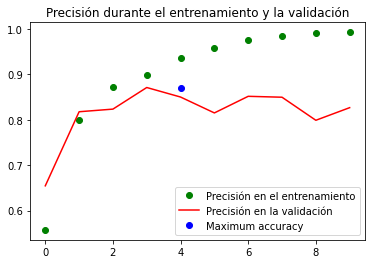

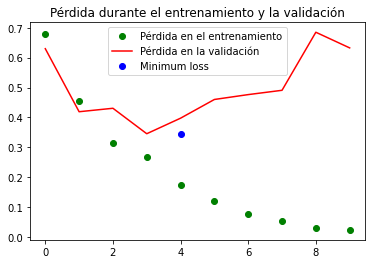

In [ ]:
import matplotlib.pyplot as plt

loss = history.history['loss']
val_loss = history.history['val_loss']
min_val_loss = min(val_loss)
min_val_loss_epoch= val_loss.index(min(val_loss)) + 1

epochs = range(len(acc))

plt.plot(epochs, loss, 'go', label='Pérdida en el entrenamiento')
plt.plot(epochs, val_loss, 'r', label='Pérdida en la validación')
plt.plot(min_val_loss_epoch, min_val_loss, 'bo', label='Minimum loss')
plt.title('Pérdida durante el entrenamiento y la validación')
plt.legend()
print("Best loss epoch : % d, Value : % .10f" %(min_val_loss_epoch, min_val_loss))

plt.show()